In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# getting the labels corresponding to the image
label_df = pd.read_csv('/kaggle/input/crowd-counting/labels.csv')
label_df.columns = ['id' , 'people']
label_df.head()

,id,people
0,1,35
1,2,41
2,3,41
3,4,44
4,5,41


In [3]:
# loading the images in vector format
img = np.load('/kaggle/input/crowd-counting/images.npy')
#img = img.reshape(img.shape[0], img.shape[1], img.shape[2], img.shape[3],1)
img.shape

(2000, 480, 640, 3)

In [4]:
labels = np.array(label_df['people'])
labels

array([35, 41, 41, ..., 25, 26, 26])

In [5]:
# setting features and target value

x_train, x_test, y_train, y_test = train_test_split(img, labels, test_size=0.1)
print(x_train.shape[0])
print(x_test.shape[0])

1800
200


In [6]:
# create model 

model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(64, (3,3), input_shape=(480,640,3), activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1)
    
])

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 478, 638, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 239, 319, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 237, 317, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 118, 158, 128)     0         
_________________________________________________________________
dropout (Dropout)            (None, 118, 158, 128)     0         
_________________________________________________________________
flatten (Flatten)            (None, 2386432)           0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

In [7]:
# add a learning rate monitor to get the lr with smoothest prediction

lr_monitor = tf.keras.callbacks.LearningRateScheduler(
                lambda epochs : 1e-8 * 10 ** (epochs/20))


In [8]:
# train the model 

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[lr_monitor])

Epoch 1/50
57/57 [==============================] - 18s 321ms/step - loss: 12.3552 - mae: 12.8484 - val_loss: 7.0518 - val_mae: 7.5436 - lr: 1.0000e-08
Epoch 2/50
57/57 [==============================] - 18s 311ms/step - loss: 11.8109 - mae: 12.3026 - val_loss: 7.2412 - val_mae: 7.7292 - lr: 1.1220e-08
Epoch 3/50
57/57 [==============================] - 18s 312ms/step - loss: 11.5032 - mae: 11.9939 - val_loss: 7.3547 - val_mae: 7.8429 - lr: 1.2589e-08
Epoch 4/50
57/57 [==============================] - 18s 310ms/step - loss: 10.6437 - mae: 11.1354 - val_loss: 6.5339 - val_mae: 7.0248 - lr: 1.4125e-08
Epoch 5/50
57/57 [==============================] - 18s 313ms/step - loss: 10.1692 - mae: 10.6612 - val_loss: 6.6941 - val_mae: 7.1753 - lr: 1.5849e-08
Epoch 6/50
57/57 [==============================] - 18s 311ms/step - loss: 9.7801 - mae: 10.2682 - val_loss: 6.3804 - val_mae: 6.8576 - lr: 1.7783e-08
Epoch 7/50
57/57 [==============================] - 18s 311ms/step - loss: 9.4431 - mae: 

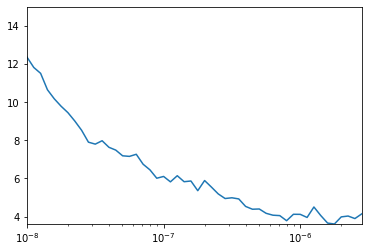

In [9]:
# plot mae
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([np.min(history.history['lr']), np.max(history.history['lr']), np.min(history.history['loss']), 15])
plt.show()

In [10]:
np.max(history.history['lr'])

2.8183829e-06

***seems like the model gives smooth results for (lr = 1e-6)***

In [11]:
# change the learning rate to 1e-5 and re-run the model

model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(lr=1e-6), metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 478, 638, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 239, 319, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 237, 317, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 118, 158, 128)     0         
_________________________________________________________________
dropout (Dropout)            (None, 118, 158, 128)     0         
_________________________________________________________________
flatten (Flatten)            (None, 2386432)           0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

In [12]:
# train the model 

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=32)

Epoch 1/100
57/57 [==============================] - 18s 313ms/step - loss: 21.5925 - mae: 3.7371 - val_loss: 8.7264 - val_mae: 2.2712
Epoch 2/100
57/57 [==============================] - 18s 312ms/step - loss: 21.1081 - mae: 3.6787 - val_loss: 10.5690 - val_mae: 2.5289
Epoch 3/100
57/57 [==============================] - 18s 310ms/step - loss: 21.8131 - mae: 3.7406 - val_loss: 20.1174 - val_mae: 3.7412
Epoch 4/100
57/57 [==============================] - 18s 310ms/step - loss: 22.2273 - mae: 3.7868 - val_loss: 10.3662 - val_mae: 2.5073
Epoch 5/100
57/57 [==============================] - 18s 310ms/step - loss: 17.1315 - mae: 3.3279 - val_loss: 10.4626 - val_mae: 2.5278
Epoch 6/100
57/57 [==============================] - 18s 312ms/step - loss: 19.2933 - mae: 3.4960 - val_loss: 8.0747 - val_mae: 2.2362
Epoch 7/100
57/57 [==============================] - 18s 311ms/step - loss: 21.7089 - mae: 3.7383 - val_loss: 13.6624 - val_mae: 2.9583
Epoch 8/100
57/57 [==============================]

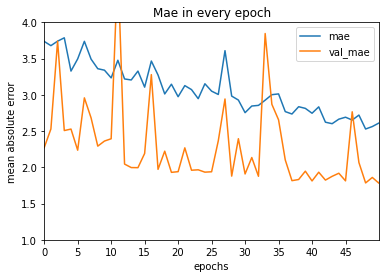

In [13]:
# plot mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['mae', 'val_mae'])
plt.ylim(1, 4)
plt.xlim(0, 50)

plt.xticks(np.arange(0,50, 5))

plt.xlabel('epochs')
plt.ylabel('mean absolute error')
plt.title('Mae in every epoch')
plt.show()

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

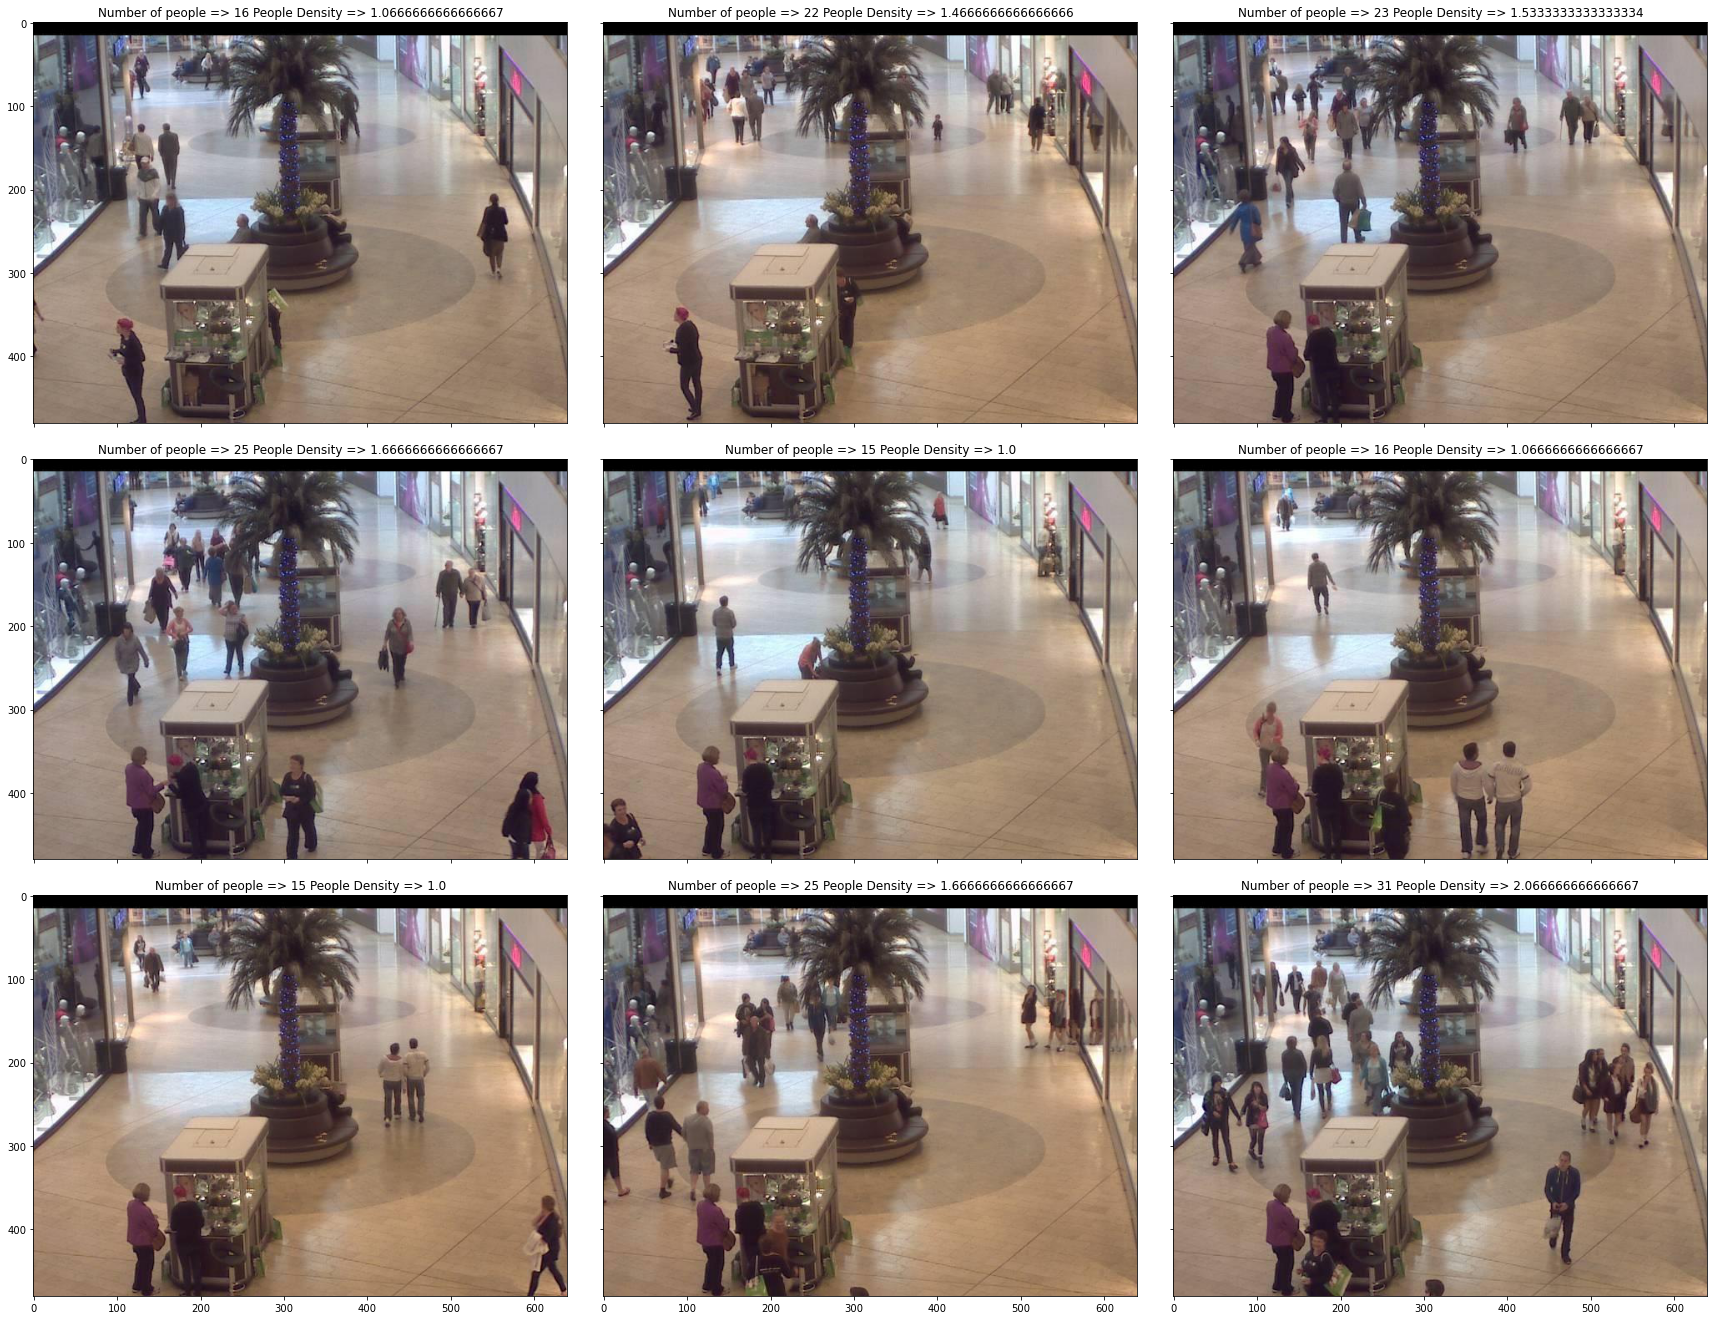

In [28]:
area = 15 # m**2
fig = plt.figure(figsize=(30,30))
grid = ImageGrid(
        fig, 111,
        nrows_ncols=(3,3),
        axes_pad=0.5
)

for x in range(10,19):
    
    grid[x-10].set_title('Number of people => ' + str(labels[x]) + ' People Density/m^2 : ' + str(int(labels[x])/area))
    grid[x-10].imshow(img[x])
    